In [122]:
### Library Imports
import pandas as pd
import yfinance as yf
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


In [123]:
### Function to Import Stock Data
def import_stock_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = yf.download(tickers, start_date, end_date)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = yf.download(tickers, start_date, end_date)['Adj Close']
    
    # Reset index to include the Date as a column
    data = data.reset_index()

    return data

tickers = ['AAPL', 'MSFT', 'GOOG', 'JNJ', 'XOM', 'TSLA', 'JPM', 'UNH', 'NVDA', 'PG']
start_date = '2019-01-01'
end_date = '2024-01-01'
stock_data = import_stock_data(tickers, start_date, end_date)
print(stock_data.tail())


[*********************100%%**********************]  10 of 10 completed


           Date        AAPL        MSFT        GOOG         JNJ         XOM  \
1253 2023-12-22  192.868149  142.370361  151.898438  164.497726  372.543945   
1254 2023-12-26  192.320206  142.470123  152.562851  165.470566  372.623505   
1255 2023-12-27  192.419830  141.093506  152.768051  166.463058  372.036713   
1256 2023-12-28  192.848206  140.933899  152.992767  167.347473  373.240112   
1257 2023-12-29  191.802170  140.584747  153.149124  167.150925  373.995972   

           TSLA         JPM         UNH        NVDA         PG  
1253  48.819527  142.584473  252.539993  516.077576  99.358162  
1254  49.268425  143.232239  256.609985  515.799866  99.582397  
1255  49.406395  143.350006  261.440002  518.537415  99.114418  
1256  49.511375  143.026123  253.179993  520.630249  97.681236  
1257  49.511375  143.821106  248.479996  522.187439  97.476486  


In [124]:
### Function to Compute Daily Returns
''' 
The percentage change in stock price from day t-1 to day t is given by:
    R(i,t) = [P(i,t) - P(i,t-1)]​ / P(i,t-1)
In our case, use the pre-built python pct_change() function
'''
def daily_returns(stock_data):
    # Drop the date column
    stock_data = stock_data.drop(columns = ['Date'])
    # Compute the percentage change
    rets = stock_data.pct_change().dropna()
    
    return rets

# Call the function to compute the daily returns for error checking
returns = daily_returns(stock_data)
print(returns.tail())

### Function to Compute Volatilities
def volatility(tickers, returns):
    # Create list to store volatilities
    volatilities = []  
    # Iterate over each ticker in tickers list
    for ticker in tickers:
        # Compute daily volatility (no annualization)
        sigma = np.std(returns[ticker])  # Removed np.sqrt(252)
        volatilities.append(round(sigma, 5))  
        
    return volatilities

# Call the function to compute the volatility for each stock
vols = volatility(tickers, returns)
print(vols)


          AAPL      MSFT      GOOG       JNJ       XOM      TSLA       JPM  \
1253 -0.005547  0.006488  0.004004 -0.000597  0.002784 -0.003266  0.007071   
1254 -0.002841  0.000701  0.004374  0.005914  0.000214  0.009195  0.004543   
1255  0.000518 -0.009662  0.001345  0.005998 -0.001575  0.002800  0.000822   
1256  0.002226 -0.001131  0.001471  0.005313  0.003235  0.002125 -0.002259   
1257 -0.005424 -0.002477  0.001022 -0.001174  0.002025  0.000000  0.005558   

           UNH      NVDA        PG  
1253 -0.007701  0.000827  0.001769  
1254  0.016116 -0.000538  0.002257  
1255  0.018822  0.005307 -0.004699  
1256 -0.031594  0.004036 -0.014460  
1257 -0.018564  0.002991 -0.002096  
[0.0203, 0.02004, 0.01251, 0.02009, 0.0192, 0.0326, 0.01333, 0.04074, 0.01858, 0.02158]


In [125]:
### Function to build Risk-Parity Portfolio
''' 
The Risk-Parity Portfolio method allocates more weight to less volatile stocks and less weight to more volatile stocks, 
aiming to equalize the contribution of each stock to the total portfolio risk. Calculation is as follows:
    1. Estimate the volatility (standard deviation) of each stock's returns
    2. Assign weights inversely proportional to the volatility:
        w(i) = (1/σ(i)) / (sum_(j=1)^10 1/σ(j))
'''
def risk_parity_weights(volatilities):
    # Empty list to store weights
    weights = []
    # Inverse sum volatilities for denominator
    inv_sum_vols = sum(1 / vol for vol in volatilities)
    # Iterate over values in volatilities list
    for vol in volatilities:
        # Weights calculation
        weight = (1 / vol) / inv_sum_vols
        weights.append(round(weight, 5))

    return weights

weights = risk_parity_weights(vols)
print('The sum of the weights is:', round(sum(weights), 6), 'and should be 1')
print(weights)


The sum of the weights is: 0.99999 and should be 1
[0.09633, 0.09758, 0.15632, 0.09734, 0.10185, 0.05999, 0.14671, 0.048, 0.10525, 0.09062]


In [126]:
### Compute Daily Portfolio Returns
''' 
The daily portfolio return is computed as the weighted sum of the returns of each stock for that particular day, equation:
   R_{portfolio,t} = (sum_(i=1)^10 w_i * R_{i,t})

For Each Day t (e.g., Day 1):
    Take the return of stock 1 on day 1 and multiply it by the weight of stock 1.
    Take the return of stock 2 on day 1 and multiply it by the weight of stock 2.
    Repeat this for all 10 stocks.

Then, sum all these weighted returns to get the portfolio return for day 1:
    R_{portfolio,t=1} = w_1R_{1,1} + w_2R_{2,1} +...+ w_10R_{10,1}
'''
# Compute the portfolio returns by multiplying the daily returns with the weights
portfolio_rets = returns.dot(weights)
# Convert portfolio rets to df
dates = stock_data['Date']
portfolio_rets_df = pd.DataFrame({
    'Date': dates,
    'Portfolio_Returns': portfolio_rets
})
# Display the portfolio returns
print(portfolio_rets_df.tail())


           Date  Portfolio_Returns
1253 2023-12-22           0.001669
1254 2023-12-26           0.003215
1255 2023-12-27           0.001066
1256 2023-12-28          -0.001425
1257 2023-12-29          -0.000463


In [127]:
### Build Variance-Covariance Matrix
''' 
The covariance between two stocks i and j is calculated as:
    Cov(R_i, R_j) = (1 / (T - 1)) * sum_{t=1}^T (R_{i,t} - R̄_i)(R_{j,t} - R̄_j)
Where:
    R_{i,t} and R_{j,t} are the daily returns of stocks i and j on day t,
    R̄_i and R̄_j are the average returns of stocks i and j over the period,
    T is the number of time periods
We will check our work using the pre-defined .cov() function
'''
def var_cov_matrix(tickers, daily_rets):
    # Initialize Empty Covariance Matrix
    num_stocks = len(daily_rets.columns)
    matrix = np.zeros((num_stocks, num_stocks))
    # Find T (number of days)
    T = len(returns)
    # Calculate the mean of each stock's returns
    mean_returns = daily_rets.mean()
    # Iterate to populate cov matrix
    for i in range(num_stocks):
        for j in range(num_stocks):
            # Covariance Matrix equation w/ indexing
            matrix[i, j] = (1 / (T - 1)) * np.sum((daily_rets.iloc[:, i] - mean_returns[i]) * (daily_rets.iloc[:, j] - mean_returns[j]))

    # Convert the covariance matrix to a DataFrame for readability
    cov_matrix_df = pd.DataFrame(matrix, index = daily_rets.columns, columns = daily_rets.columns)

    return cov_matrix_df

cov_matrix = var_cov_matrix(tickers, returns)
print(cov_matrix)


          AAPL      MSFT      GOOG       JNJ       XOM      TSLA       JPM  \
AAPL  0.000412  0.000274  0.000103  0.000186  0.000296  0.000435  0.000120   
MSFT  0.000274  0.000402  0.000086  0.000176  0.000290  0.000408  0.000100   
GOOG  0.000103  0.000086  0.000157  0.000104  0.000100  0.000095  0.000100   
JNJ   0.000186  0.000176  0.000104  0.000404  0.000174  0.000246  0.000105   
XOM   0.000296  0.000290  0.000100  0.000174  0.000369  0.000443  0.000124   
TSLA  0.000435  0.000408  0.000095  0.000246  0.000443  0.001064  0.000126   
JPM   0.000120  0.000100  0.000100  0.000105  0.000124  0.000126  0.000178   
UNH   0.000404  0.000333  0.000055  0.000226  0.000355  0.000666  0.000066   
NVDA  0.000171  0.000149  0.000121  0.000178  0.000173  0.000210  0.000117   
PG    0.000139  0.000130  0.000083  0.000256  0.000116  0.000169  0.000068   

           UNH      NVDA        PG  
AAPL  0.000404  0.000171  0.000139  
MSFT  0.000333  0.000149  0.000130  
GOOG  0.000055  0.000121  0.00

### Covariance Between Two Stocks:
Each element in the covariance matrix represents the covariance between two stocks. Covariance is a measure of how two stocks' returns move together:

- **Positive Covariance**: If the covariance between two stocks is positive, it means that their returns tend to move in the same direction. When one stock’s return increases, the other’s return is likely to increase as well.
- **Negative Covariance**: A negative covariance indicates that the returns of the two stocks move in opposite directions. When one stock’s return increases, the other’s return tends to decrease.
- **Zero Covariance**: If the covariance is close to zero, the two stocks are not strongly correlated, meaning their returns move independently of each other.

### Variance of Each Stock (Diagonal Elements):
The diagonal elements of the covariance matrix represent the variance of each individual stock, which is the covariance of the stock with itself.
Variance is a measure of the dispersion of a stock’s returns around its mean. A higher variance means the stock’s returns are more spread out, indicating higher volatility (risk).

For stock \(i\), the variance is:
    Var(R_i) = Cov(R_i, R_i)


In [128]:
### Calculate Portfolio Variance and Volatility
''' 
The portfolio variance is calculated as:
    Var(R_{portfolio}) = w^T \Sigma w
Where:
- w^T is the transpose of the weight vector
- Sigma is the covariance matrix
- w is the vector of portfolio weights
'''
def calc_var_and_vol(weights, cov_matrix):
    # Compute transpose of weights matrix
    weights_arr = np.array(weights) # Convert weights to an array
    transpose = weights_arr.T
    # Perform matrix multiplication (dot product) between covariance matrix and weights vector
    prod = np.dot(cov_matrix, weights)
    # Compute the dot product between prod and the weights transpose
    var = np.dot(transpose, prod)

    # Compute the portfolio volatility = sqrt(var)
    vol = np.sqrt(var)

    return var, vol

variance, volatility = calc_var_and_vol(weights, cov_matrix)
print('Variance:', variance)
print('Volatility:', volatility)


Variance: 0.0001822639751559573
Volatility: 0.013500517588446649


In [129]:
### Calculate Market Returns
def market_returns():
    # Get market returns
    mkt_data = yf.download('^GSPC', start = '2019-01-01', end = '2024-01-01')['Adj Close']  # S&P 500 index
    mkt_rets = mkt_data.pct_change().dropna()
    # Calculate the average return (expected return of the market)
    R_m = np.mean(mkt_rets)
    # Annualized return
    ann_R_m = ((1 + R_m) ** 252) - 1  # 252 trading days in a year

    return mkt_rets, ann_R_m

# Function call to compute the market returns and the annualized R_m
market_rets, annualized_R_m = market_returns()
print('Coomputed Market Returns:', market_rets)
print('Annualized Expected Return of the Market:', round(annualized_R_m, 4), 'and the percentage is:', str(round(annualized_R_m * 100, 2)) + '%')


[*********************100%%**********************]  1 of 1 completed

Coomputed Market Returns: Date
2019-01-03   -0.024757
2019-01-04    0.034336
2019-01-07    0.007010
2019-01-08    0.009695
2019-01-09    0.004098
                ...   
2023-12-22    0.001660
2023-12-26    0.004232
2023-12-27    0.001430
2023-12-28    0.000370
2023-12-29   -0.002826
Name: Adj Close, Length: 1257, dtype: float64
Annualized Expected Return of the Market: 0.1636 and the percentage is: 16.36%


In [130]:
### Calculate Beta
''' 
The beta of a stock i is calculated as:
    Beta_i = Cov(R_i, R_m) / Var(R_m)
Where:
- R_i is the return of the stock
- R_m is the return of the market (we'll use the S&P 500)
- Cov(R_i, R_m) is the covariance between the stock and the market
- Var(R_m) is the variance of the market return
'''
def get_beta(mkt_rets, daily_rets):
    # Create empty list to store betas
    betas = []
    # Ensure daily_rets is indexed by the same dates as market_rets
    daily_rets = daily_rets.set_index(mkt_rets.index)
    
    # Iterate over each stock in daily_rets cols to calculate Cov(R_i, R_m)
    for stock in daily_rets.columns:
        # Calculate covariance between each stock and market
        cov_matrix = np.cov(daily_rets[stock], mkt_rets)
        # Covariance between the stock and market is at position [0, 1]
        covariance = cov_matrix[0, 1]
        # Calculate variance of market returns
        mkt_var = np.var(mkt_rets)
        # Calculate beta
        beta = covariance / mkt_var
        betas.append(round(beta, 5))

    return betas

# Function call to return Betas
betas = get_beta(market_rets, returns)
print(betas)


[1.21659, 1.1317, 0.52445, 1.09952, 1.18308, 1.73021, 0.58526, 1.50446, 0.86173, 0.88562]


In [131]:
### Compute Expected Returns via CAPM
''' 
CAPM Formula:
    R_{expected} = R_f + Beta*(R_m - R_f)
Where:
- R_f is the risk-free rate (ex - bond yield)
- Beta is the stock's beta, a measure of its sensitivity to the market
- R_m is the expected return of the market (S&P 500)
- R_m - R_f is called the market risk premium
'''
def capm(r_f, betas, ann_r_m):
    # create empty array for expected return vals
    r_expected = []
    # calculate market risk premium
    mkt_risk_prem = ann_r_m - r_f
    # compute CAPM expected returns
    for beta in betas:
        r_exp = r_f + beta*mkt_risk_prem
        r_expected.append(round(r_exp, 5))
    
    return r_expected

# Return CAPM expected returns function
r_f = 0.02
expected_rets = capm(r_f, betas, annualized_R_m)
print(expected_rets)


[0.19473, 0.18254, 0.09532, 0.17792, 0.18992, 0.2685, 0.10406, 0.23608, 0.14376, 0.1472]


In [132]:
### Portfolio Expected Return
''' 
The expected return of the portfolio is calculated as the weighted sum of the individual stock returns:
    R_{portfolio} = \sum_{i=1}^{N} w_i * R_i
Where:
- R_i is the expected return of each stock
- w_i is the weight of each stock in the portfolio
'''
def calc_exp_port_rets(exp_rets, weights):
    # Calculate the total portfolio expected return by summing weighted returns
    exp_port_ret = 0  # Initialize total expected return
    # Iterate over the indices of the expected rets or weights list
    for i in range(len(exp_rets)):
        port_ret = exp_rets[i] * weights[i]
        exp_port_ret += port_ret
    
    # Convert annualized expected portfolio return to daily for daily VaR time horizon
    daily_exp_port_ret = exp_port_ret / 252

    return exp_port_ret, daily_exp_port_ret

# Example usage
ann_exp_port_ret, daily_expected_portfolio_return = calc_exp_port_rets(expected_rets, weights)
print("Daily Expected Portfolio Return:", daily_expected_portfolio_return)
print("Annual Expected Portfolio Return:", ann_exp_port_ret)


Daily Expected Portfolio Return: 0.0006321781861111111
Annual Expected Portfolio Return: 0.1593089029


In [138]:
### Compute Variance-Covariance VaR
def compute_vcv_var(cov_matrix, weights, confidence_level = 0.95, time_horizon = 1):
    # Convert weights to a numpy array
    weights_arr = np.array(weights)
    # Compute portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights_arr.T, np.dot(cov_matrix, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)  # Portfolio standard deviation

    # Get the z-score for the given confidence level
    z_score = stats.norm.ppf(1 - confidence_level)

    # Calculate VCV VaR
    vcv_var_value = z_score * portfolio_volatility * np.sqrt(time_horizon)
    
    return vcv_var_value

# Calculate VCV VaR
vcv_var = compute_vcv_var(cov_matrix, weights)
print(f"VCV VaR at 95% confidence level: {vcv_var}")
print(f'The Parametric VaR at 95% confidence level of {vcv_var:.4f} means that, under normal market conditions, '
      f'there is a 95% probability that the maximum expected loss of your portfolio over the given time horizon '
      f'of one day will not exceed {vcv_var * 100:.2f}% of the portfolio\'s value.')


VCV VaR at 95% confidence level: -0.022206375321078612
The Parametric VaR at 95% confidence level of -0.0222 means that, under normal market conditions, there is a 95% probability that the maximum expected loss of your portfolio over the given time horizon of one day will not exceed -2.22% of the portfolio's value.


In [137]:
### Parametric VaR calculation
''' 
You can calculate VaR using the following formula for normal distribution:
    VaR = mu_p - z_alpha * sigma_p
Where:
- mu_p is the portfolio's expected return
- z_alpha is the z-score corresponding to the confidence level (e.g., -1.645 for 95% confidence)
- sigma_p is the portfolio's standard deviation (volatility)
'''
def parametric_var(expected_return, portfolio_volatility, confidence_level = 0.95, time_horizon = 1):
    # Get the z-score for the given confidence level (negative because we focus on losses)
    z_score = stats.norm.ppf(1 - confidence_level)
    # Calculate VaR
    var = expected_return - z_score * portfolio_volatility * np.sqrt(time_horizon)
    # Flip the sign to negative to indicate portfolio losses
    neg_var = -var
    
    return neg_var

# Function Call to Calculate VaR
para_var = parametric_var(daily_expected_portfolio_return, volatility, confidence_level = 0.95, time_horizon = 1)
print(f"Parametric VaR at 95% confidence level: {para_var}")
print(f'The Parametric VaR at 95% confidence level of {para_var:.4f} means that, under normal market conditions, '
      f'there is a 95% probability that the maximum expected loss of your portfolio over the given time horizon '
      f'of one day will not exceed {para_var * 100:.2f}% of the portfolio\'s value.')


Parametric VaR at 95% confidence level: -0.022838553507189722
The Parametric VaR at 95% confidence level of -0.0228 means that, under normal market conditions, there is a 95% probability that the maximum expected loss of your portfolio over the given time horizon of one day will not exceed -2.28% of the portfolio's value.


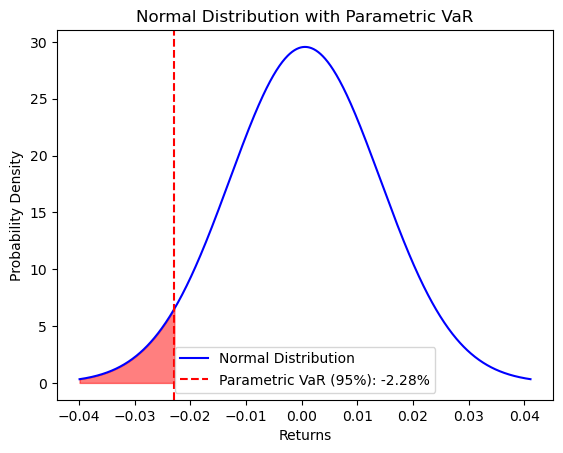

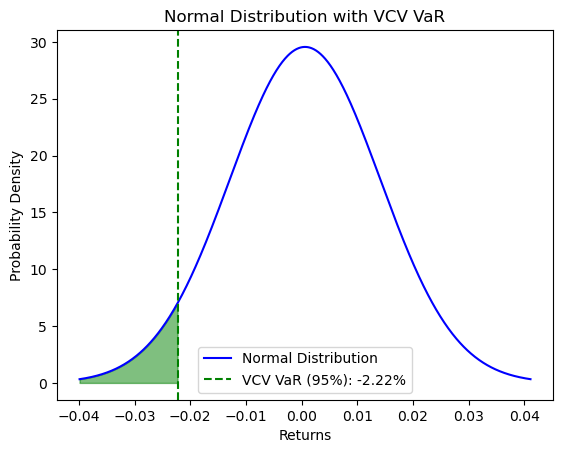

In [139]:
### Function to Plot VaR Graph (for both Parametric and VCV VaR)
def plot_var_graph(var_type, mu, sigma, var_value, confidence_level = 0.95, title = 'VaR Graph'):
    # Generate a range of portfolio returns (x-axis values)
    x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 1000)
    
    # Generate the probability density function (pdf) values for the normal distribution
    y = stats.norm.pdf(x, mu, sigma)
    
    # Plot the normal distribution curve
    plt.plot(x, y, label = 'Normal Distribution', color = 'blue')
    
    # Add a vertical line at the VaR threshold
    plt.axvline(var_value, color = 'red' if var_type == 'Parametric' else 'green', linestyle='--', 
                label=f'{var_type} VaR ({int(confidence_level * 100)}%): {var_value:.2%}')
    
    # Fill the area under the curve to the left of the VaR threshold
    plt.fill_between(x, 0, y, where = (x <= var_value), color = 'red' if var_type == 'Parametric' else 'green', alpha = 0.5)
    
    # Add labels and title
    plt.title(title)
    plt.xlabel('Returns')
    plt.ylabel('Probability Density')
    
    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()

# Graph Parametric VaR
plot_var_graph(var_type = 'Parametric', mu = daily_expected_portfolio_return, sigma = volatility, 
               var_value = para_var, title = 'Normal Distribution with Parametric VaR')
# Graph VCV VaR
plot_var_graph(var_type = 'VCV', mu = daily_expected_portfolio_return, sigma = volatility, 
               var_value = vcv_var, title = 'Normal Distribution with VCV VaR')
